## Spam Email Classification 
In this project,I will create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. Goals are to demonstrate the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

# Initial Analysis

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to Kaggle for evaluation.

In [2]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Mon Dec 28 12:09:07 2020
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Mon Dec 28 12:09:04 2020
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0



### First, let's check if our data contains any missing values. 

In [3]:
a = original_training_data["subject"].isnull().value_counts()[True]
b = original_training_data["email"].isnull().value_counts()
b

False    8348
Name: email, dtype: int64

In [4]:
print("Num NaN in subject: "+ str(a))
print("Num NaN in email: "+ str(len(original_training_data["email"])-b[False]))
original_training_data.fillna(value="",inplace=True)

Num NaN in subject: 6
Num NaN in email: 0


### Let's get a an example of a spam and a ham email

In [5]:
first_ham = original_training_data.loc[0,"email"]
first_spam = original_training_data.loc[2,"email"]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



The second email has html tags in the text which is suspicious and also talks about increasing hammer size.

## Training Validation Split

In [6]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

In [7]:
val.head()


,id,subject,email,spam
6475,6475,Subject: RE: My brain hurts\n,"> someone tell me a joke, or email me a beer o...",0
4559,4559,Subject: Re: [fwd: error exmh 2.5 07/13/2001 ]\n,--==_exmh_601800448p\n content-type: text/plai...,0
7977,7977,Subject: Re: [ILUG] How to copy some files\n,"on sun, jul 21, 2002 at 01:47:39am +0100, paul...",0
4350,4350,Subject: Re: OpenGL\n,"on thu, 1 aug 2002 17:10:48 +0100, john hinsle...",0
5593,5593,Subject: Re: req: Falcon's eye\n,"on tue, jul 30, 2002 at 12:17:21am +0300, vill...",0



## Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. You can also use other methods such as Naive Bayes or Random Forest

In [8]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = np.array([texts.str.contains(x).astype(int) for x in words]).T
    return indicator_array
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


In [9]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variable, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variable, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


### Let's see the distribution of suspicious words between spam and ham emails

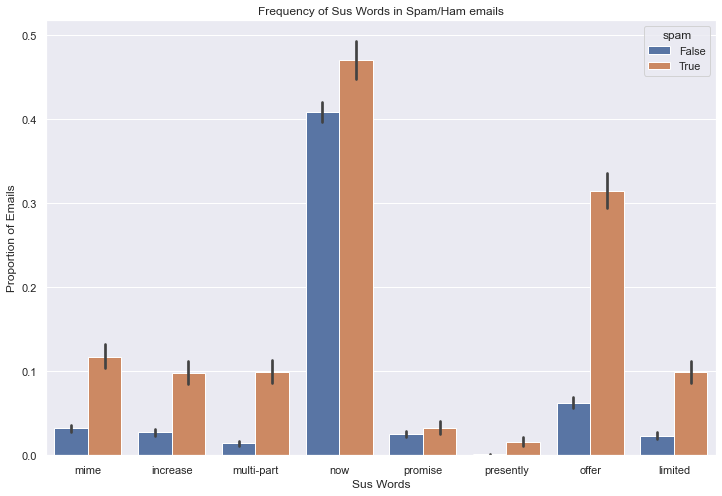

In [10]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
scam_words = ["mime","increase","multi-part","now","promise","presently","offer","limited"]
scam = pd.DataFrame(words_in_texts(scam_words,train["email"]),columns=scam_words)
scam.insert(0,"spam",(train["spam"]==1))
scam.head(25)
#train[train["spam"]==1][["email"]]
scam_melt = scam.melt("spam")
sns.set()
plt.figure(figsize=(12,8))
sns.barplot(x="variable",y="value",hue="spam",data = scam_melt)
plt.ylabel("Proportion of Emails")
plt.xlabel("Sus Words")
plt.title("Frequency of Sus Words in Spam/Ham emails");

### What about email length?

C:\Users\Bear\anaconda3\envs\Spam\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Bear\anaconda3\envs\Spam\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


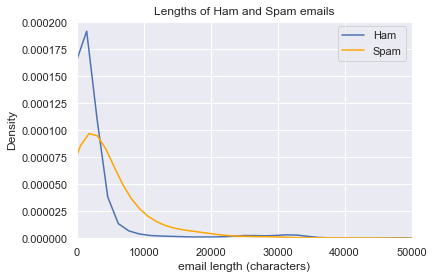

In [11]:
lengths = train["email"].apply(len)
scam["email length"] = lengths
ham_lens = scam[scam["spam"]==False]["email length"]
scam_lens = scam[scam["spam"]==True]["email length"]
plt.xlim(right=50000)
sns.distplot(ham_lens,hist=False,label="Ham")
sns.distplot(scam_lens,color="orange",hist=False,label="Spam")
plt.title("Lengths of Ham and Spam emails")
plt.xlabel("email length (characters)")
plt.legend();

The plot above describes the distribution of email lengths between ham and spam emails. It seems that spam emails are generally very short

# Basic Classification

### Let's create our X matrix to train the classifier. We can use the words_in_texts function to do this


In [12]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words,train["email"])
Y_train = train["spam"]

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
training_accuracy = accuracy_score(Y_train,Y_pred)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

In [14]:
def extract_evaluations(y,y_hat):
    TP,FP,TN,FN = 0,0,0,0
    for i in range(len(y)):
        if y[i]==0 & y_hat[i]==0:
            TN += 1
        elif y[i]==0 & y_hat[i]==1:
            FP += 1
        elif y[i]==1 & y_hat[i]==1:
            TP += 1
        else:
            FN += 1
    return [TP,FP,TN,FN]

In [15]:
evaluations = extract_evaluations(Y_train,Y_pred)
evaluations

[219, 0, 5595, 1699]

In [16]:
logistic_predictor_precision = evaluations[0]/(evaluations[0]+evaluations[1])
logistic_predictor_recall = evaluations[0]/(evaluations[0]+evaluations[3])
logistic_predictor_far = evaluations[1]/(evaluations[1]+evaluations[2])
[logistic_predictor_precision,logistic_predictor_recall,logistic_predictor_far]

[1.0, 0.11418143899895725, 0.0]

# Model Iteration

steps: scan through all emails and catelog each word, adding one each time it's seen. 

In [17]:
def clean(data):
    data.fillna(value="",inplace=True)
    data["email"] = data["email"].str.replace("\\n|>|<| \)|&nbsp|nbsp","",regex=True)
    data["subject"] = data["subject"].str.replace("\\n|>|<| \)|&nbsp|nbsp","",regex=True)
    data["subject"] = data["subject"].str.replace("Subject: ","")
    return data


In [18]:
def count_instances(pattern,string):
    return len(re.findall(pattern,string))
def count_words(string):
    return count_instances("\w+",string)
def is_reply(string):
    return int("RE:" in string or "re:" in string or "Re:" in string)
def num_exclamations(string):
    return count_instances("!",string)
def num_capitals(string):
    return count_instances("[A-Z]",string)
def num_char(string):
    return len(string)
def count_hash(string):
    return count_instances("#",string)

In [19]:
def create_feature_matrix(df):
    cleaned = clean(df)
    words = ["multi-part","increase","wad","promise",
            "presently","offer","limited",
            "click here","money","free","text","call",
            "lose weight","html","body","</",
            "message","3d","linux","font","spamassasin",
             "mime","Business","center","please","newsisfree",
            "archives","dear","investment","userland","wrote","table"]
    features = pd.DataFrame(words_in_texts(words,cleaned["email"]),columns=words)
    
    features["num_hashtag"] = cleaned["email"].apply(count_hash)
    features["char_count"] = cleaned["email"].apply(len)
    features["sub_word_count"] = cleaned["subject"].apply(count_words)
    features["email_word_count"] = cleaned["email"].apply(count_words)
   
    features["is_reply"] = cleaned["subject"].apply(is_reply)
    features["email_!"] = cleaned["email"].apply(num_exclamations)
    features["subject_!"] = cleaned["subject"].apply(num_exclamations)
    features["num_capitals"] = cleaned["subject"].apply(num_capitals)
  
    return features

In [20]:
feats = create_feature_matrix(train)
feats.head()

,multi-part,increase,wad,promise,presently,offer,limited,click here,money,free,...,wrote,table,num_hashtag,char_count,sub_word_count,email_word_count,is_reply,email_!,subject_!,num_capitals
0,0,0,0,0,0,0,0,0,0,1,...,0,0,5,1586,5,234,0,2,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,5,4626,6,789,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1327,7,186,1,3,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4312,10,719,0,2,1,11
4,0,0,0,0,0,1,0,0,0,1,...,1,1,107,30115,9,5009,0,44,0,9


In [21]:
y_train = train.loc[:,'spam']

In [22]:
x_train = feats

In [23]:
len(feats.columns)

40

In [24]:
from sklearn.model_selection import cross_validate,KFold,cross_val_score
from sklearn.linear_model import LogisticRegressionCV
m = LogisticRegression(C=.5,penalty="l1",solver="liblinear").fit(x_train,y_train)
cv_results = cross_val_score(m,x_train,y_train,cv=5)
np.mean(cv_results)



0.9343807724099072

1. I found better features for the model by searching through spam texts and choosing common words. The words couldn't be too common or else they'll prominently show up in ham emails too.
2. I tried to filter by the presence of "url = http://". However there wasn't much of a relationship between that and spam vs. ham since links are common in both ham and spam and since they are generally unique, it's not a good generalization between the two catgories. 
3. I was surprised that html tags were so prevalent in spam emails, since its just a language. 

### Let's create a Wordcloud to see the most common words in ham emails

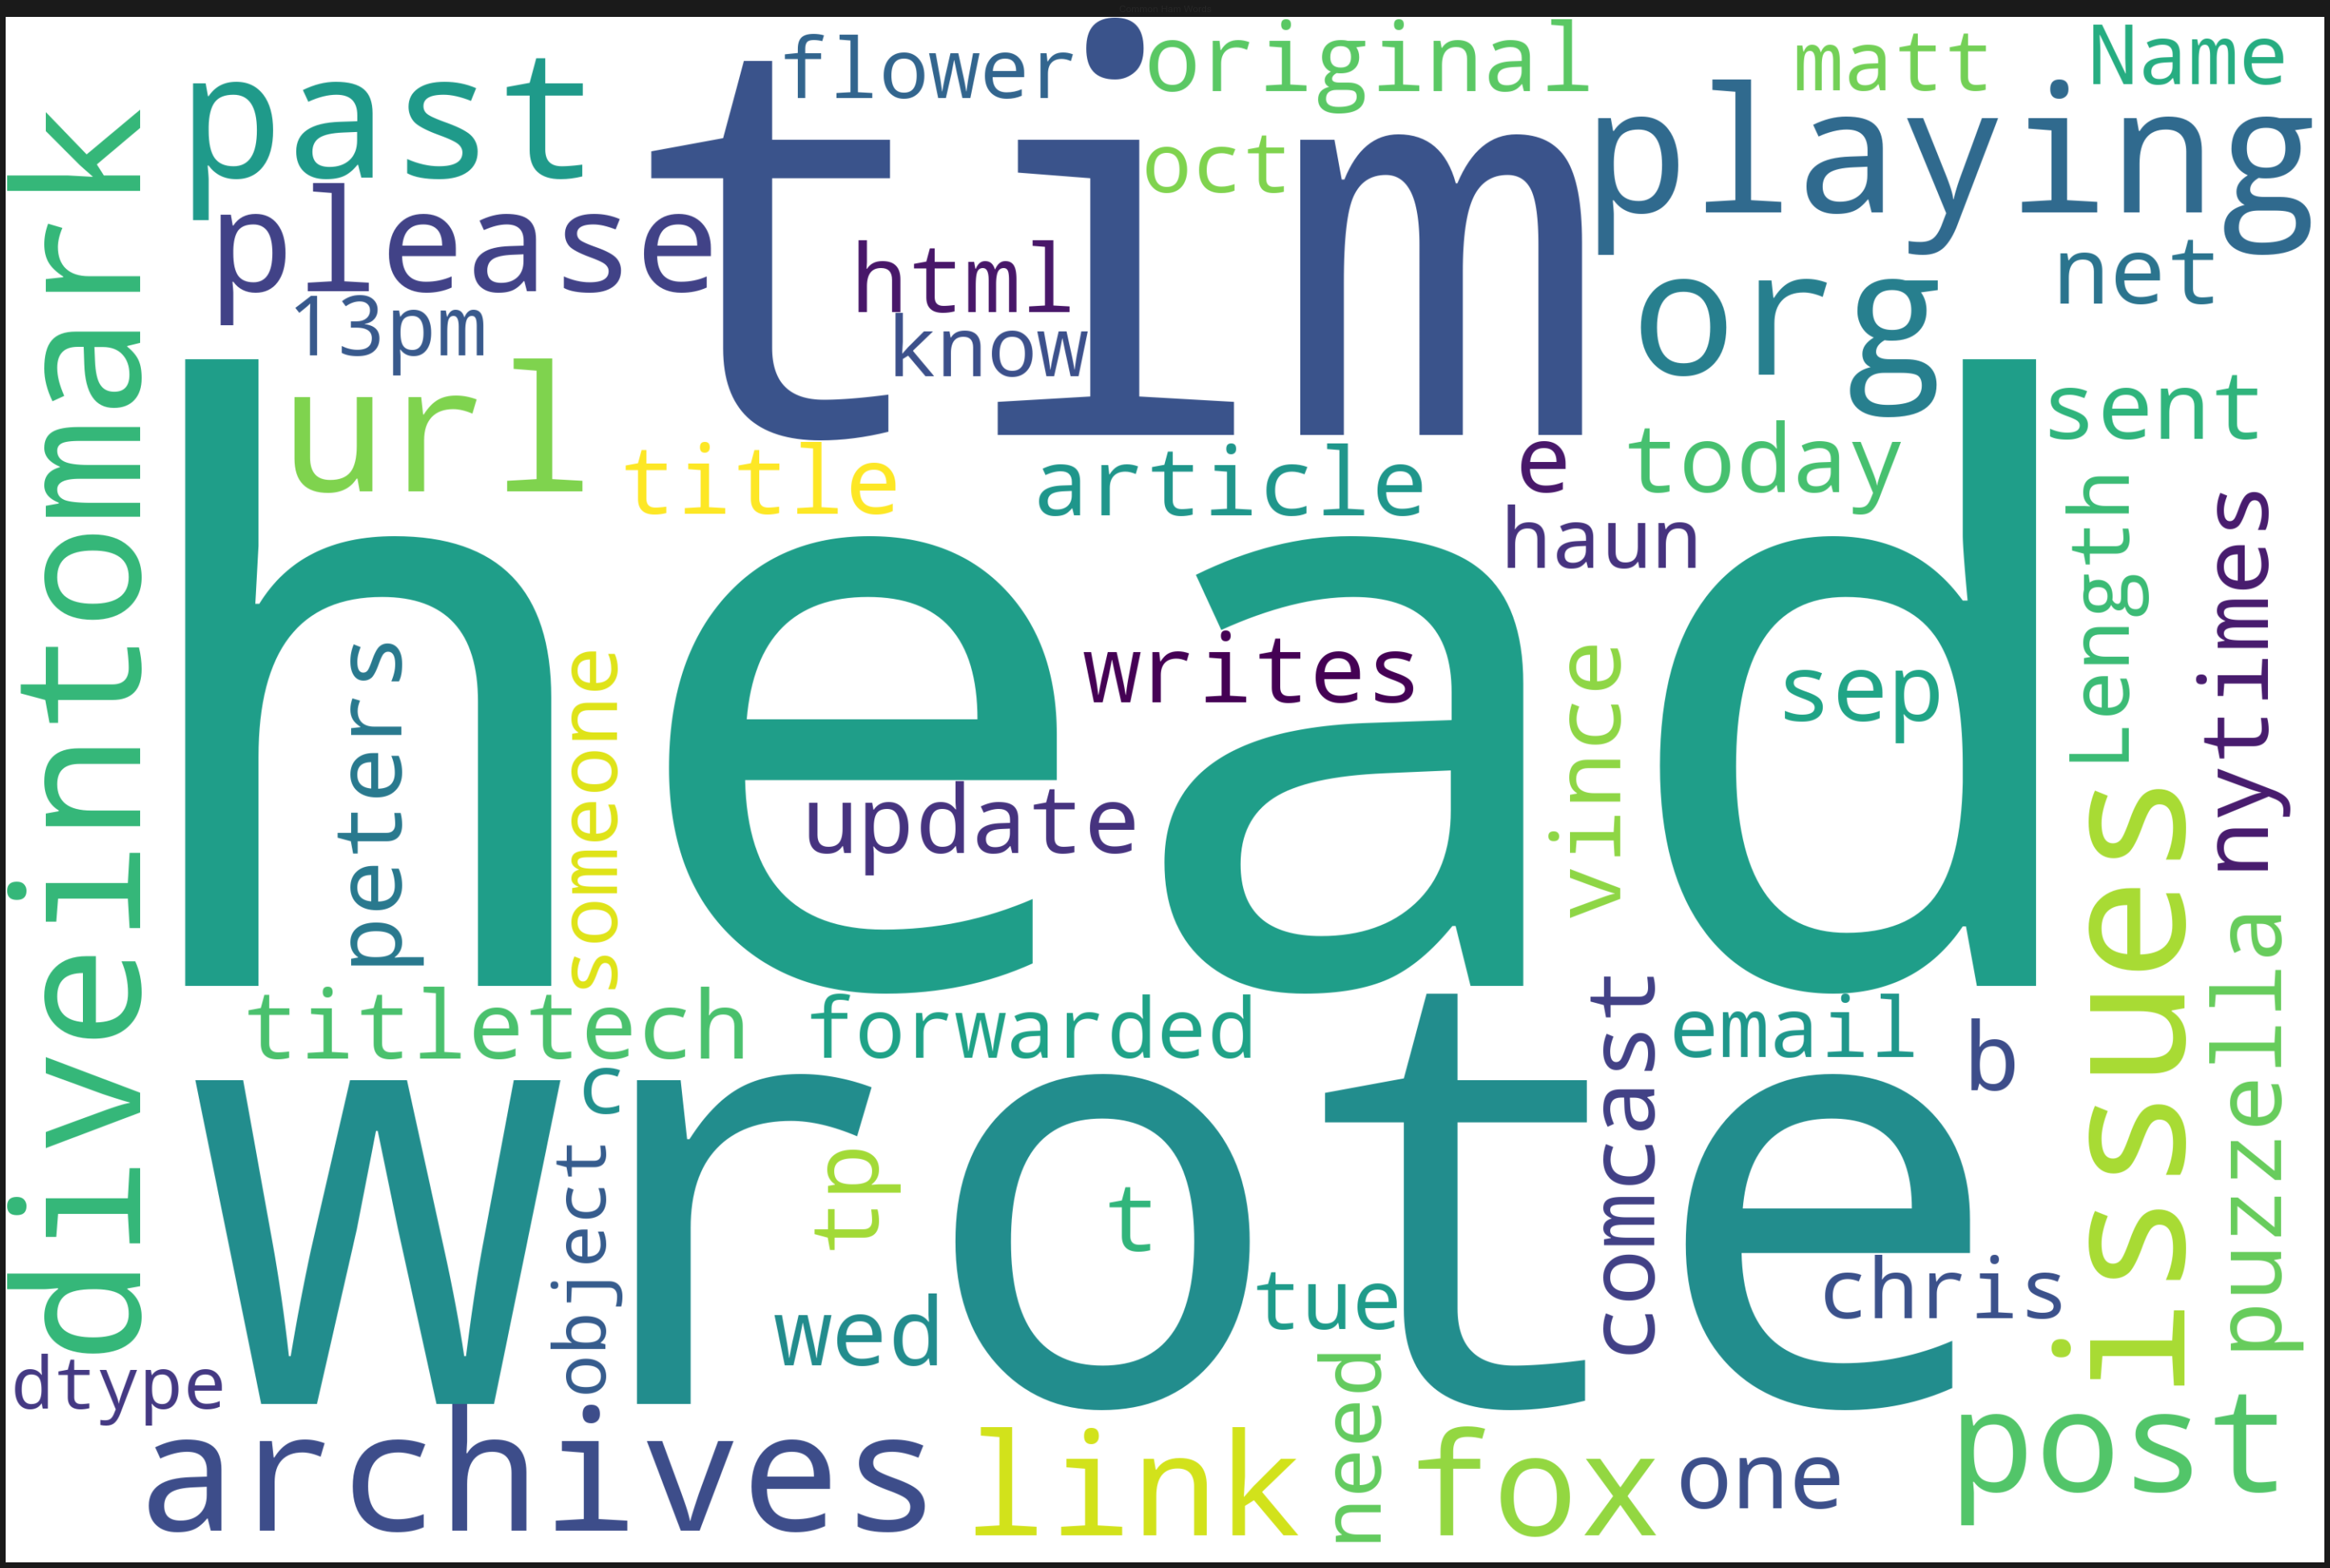

In [27]:
#This visualization shows the most common words from ham emails.
#You can use this to select unique, common words for your features so that the difference between spam and ham is greater
from wordcloud import WordCloud, STOPWORDS

common_words = {}
def scan_emails(string):
    r = re.findall("\w+",string)
    for x in r:
        if x in common_words:
            common_words[x]+=1
        else:
            common_words[x] = 1
    return string
cleaned = clean(train)
common_ham_words = pd.Series(cleaned[cleaned["spam"]==0]["email"].apply(scan_emails))


text = common_ham_words
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = "white",
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Common Ham Words")
plt.show()

Here's the ROC curve for my improved model, which is significantly better than the original basic classification I did.

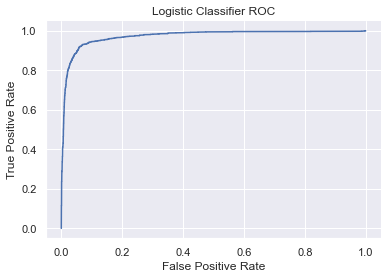

In [26]:
from sklearn.metrics import roc_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes
y_predicted = m.predict_proba(x_train)
fpr,tpr,_ = roc_curve(y_train, y_predicted[:,1])
with sns.axes_style("darkgrid"):
    plt.plot(fpr, tpr)

sns.despine()
plt.title('Logistic Classifier ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');